<a href="https://colab.research.google.com/github/DJCordhose/ai/blob/master/notebooks/2019_tf/autoencoders_stabilize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders: Stabilitzing results

* Losses
   * https://keras.io/losses/
   * Predefined loss functions: https://github.com/keras-team/keras/blob/master/keras/losses.py
   * Example custom loss function: https://stackoverflow.com/questions/43818584/custom-loss-function-in-keras
   * Loss function that is not f(y_true, y_pred): https://github.com/keras-team/keras/issues/2662
* Having more than one input/output, combined losses: https://keras.io/getting-started/functional-api-guide/
* Normalizaing data: https://www.tensorflow.org/api_docs/python/tf/keras/utils/normalize
* Initializers: https://keras.io/initializers/

In [1]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

1.12.0


In [2]:
!curl -O https://raw.githubusercontent.com/DJCordhose/deep-learning-crash-course-notebooks/master/data/insurance-customers-1500.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 26783  100 26783    0     0  83177      0 --:--:-- --:--:-- --:--:-- 82919


In [0]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Flatten, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical


In [0]:
import pandas as pd
df = pd.read_csv('./insurance-customers-1500.csv', sep=';')
one_hot_groups = pd.DataFrame(to_categorical(df['group']), columns={'red', 'green', 'yellow'})
main = df.drop('group', axis='columns')

In [5]:
main.head()

,speed,age,miles
0,98.0,44.0,25.0
1,118.0,54.0,24.0
2,111.0,26.0,34.0
3,97.0,25.0,10.0
4,114.0,38.0,22.0


In [6]:
one_hot_groups.head()

,green,yellow,red
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,0.0,0.0,1.0
4,0.0,1.0,0.0


### Challenge: we could feed in both parts in a united way, but they need different loss functions

* write a custom loss function that does this and balances the value: https://keras.io/losses/
* create multi-in/out model that makes this a little bit more transparent: https://keras.io/getting-started/functional-api-guide/#multi-input-and-multi-output-models

In [7]:
# often does not even train, so choose a seed known to be good
from tensorflow.keras.initializers import glorot_normal
seed= 17

from tensorflow.keras.layers import concatenate, average, add

# first multi in
main_input = Input(shape=(3,), name='main_input')
group_input = Input(shape=(3,), name='group_input')

# hopefully this balances out inputs to same scale
encoded_main = Dense(units=2, activation='relu', name="main_encoder", bias_initializer='zeros', kernel_initializer=glorot_normal(seed=seed))(main_input)
encoded_group = Dense(units=2, activation='relu', name="group_encoder", bias_initializer='zeros', kernel_initializer=glorot_normal(seed=seed))(group_input)

# latent representation

merged = concatenate([encoded_main, encoded_group])
# this might work as well
# merged = average([encoded_main, encoded_group])

# the effective latent encoding
encoding_dim = 2
encoded = Dense(units=encoding_dim, activation='relu', name="encoder", bias_initializer='zeros', kernel_initializer=glorot_normal(seed=seed))(merged)

# then multi out
main_output = Dense(units=3, activation='linear', name="main_output", bias_initializer='zeros', kernel_initializer=glorot_normal(seed=seed))(encoded)
group_output = Dense(units=3, activation='softmax', name="group_output", bias_initializer='zeros', kernel_initializer=glorot_normal(seed=seed))(encoded)

autoencoder = Model(inputs=[main_input, group_input], outputs=[main_output, group_output])

adam = keras.optimizers.Adam(lr=0.01)
# adam = keras.optimizers.Adam()

autoencoder.compile(optimizer=adam,
              loss={'main_output': 'mae', 'group_output': 'categorical_crossentropy'},
              loss_weights={'main_output': 1., 'group_output': 50.})

autoencoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 3)            0                                            
__________________________________________________________________________________________________
group_input (InputLayer)        (None, 3)            0                                            
__________________________________________________________________________________________________
main_encoder (Dense)            (None, 2)            8           main_input[0][0]                 
__________________________________________________________________________________________________
group_encoder (Dense)           (None, 2)            8           group_input[0][0]                
__________________________________________________________________________________________________
concatenat

In [8]:
BATCH_SIZE = 1
EPOCHS=10

%time history = autoencoder.fit(\
    x={'main_input': main, 'group_input': one_hot_groups},\
    y={'main_output': main, 'group_output': one_hot_groups},\
    epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True, verbose=1)

Epoch 1/10
1500/1500 [==============================] - 10s 7ms/step - loss: 62.0372 - main_output_loss: 47.9435 - group_output_loss: 0.2819
Epoch 2/10
1500/1500 [==============================] - 9s 6ms/step - loss: 36.5832 - main_output_loss: 33.3895 - group_output_loss: 0.0639
Epoch 3/10
1500/1500 [==============================] - 9s 6ms/step - loss: 31.5609 - main_output_loss: 29.6735 - group_output_loss: 0.0377
Epoch 4/10
1500/1500 [==============================] - 9s 6ms/step - loss: 28.3381 - main_output_loss: 27.0141 - group_output_loss: 0.0265
Epoch 5/10
1500/1500 [==============================] - 9s 6ms/step - loss: 25.0030 - main_output_loss: 23.6828 - group_output_loss: 0.0264
Epoch 6/10
1500/1500 [==============================] - 9s 6ms/step - loss: 21.1347 - main_output_loss: 19.3685 - group_output_loss: 0.0353
Epoch 7/10
1500/1500 [==============================] - 9s 6ms/step - loss: 19.4739 - main_output_loss: 17.8124 - group_output_loss: 0.0332
Epoch 8/10
1500/150

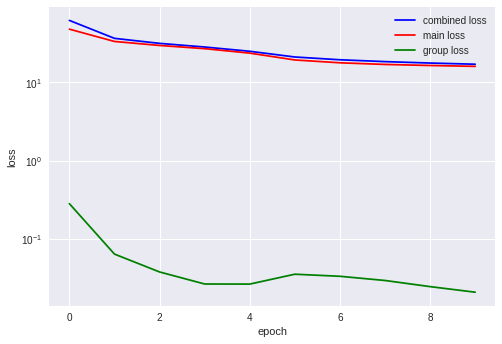

In [9]:
import matplotlib.pyplot as plt

plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')

plt.plot(history.history['loss'], 'b')
plt.plot(history.history['main_output_loss'], 'r')
plt.plot(history.history['group_output_loss'], 'g')

plt.legend(['combined loss', 'main loss', 'group loss'], loc='upper right')

In [0]:
samples = df.sample(10).reset_index(drop=True)
main_samples = samples.drop('group', axis='columns')
group_samples = pd.DataFrame(to_categorical(samples['group']), columns={'red', 'green', 'yellow'})

In [11]:
merged_samples = pd.concat([main_samples, group_samples], axis=1)
merged_samples

,speed,age,miles,green,yellow,red
0,126.0,34.0,34.0,1.0,0.0,0.0
1,124.0,67.0,22.0,1.0,0.0,0.0
2,106.0,35.0,35.0,1.0,0.0,0.0
3,141.0,49.0,67.0,0.0,0.0,1.0
4,102.0,24.0,6.0,0.0,0.0,1.0
5,144.0,61.0,29.0,0.0,0.0,1.0
6,153.0,38.0,55.0,1.0,0.0,0.0
7,150.0,39.0,51.0,1.0,0.0,0.0
8,105.0,31.0,22.0,0.0,1.0,0.0
9,119.0,69.0,41.0,0.0,0.0,1.0


In [12]:
autoencoder.predict([main_samples, group_samples])

[array([[118.42957 ,  41.323223,  29.63947 ],
        [118.42957 ,  41.323223,  29.63947 ],
        [118.42957 ,  41.323223,  29.63947 ],
        [141.43462 ,  43.064613,  32.28809 ],
        [141.43462 ,  43.064613,  32.28809 ],
        [141.43462 ,  43.064613,  32.28809 ],
        [118.42957 ,  41.323223,  29.63947 ],
        [118.42957 ,  41.323223,  29.63947 ],
        [ 98.26651 ,  39.79696 ,  27.31805 ],
        [141.43462 ,  43.064613,  32.28809 ]], dtype=float32),
 array([[9.6638060e-01, 1.0208833e-02, 2.3410549e-02],
        [9.6638060e-01, 1.0208833e-02, 2.3410549e-02],
        [9.6638060e-01, 1.0208833e-02, 2.3410549e-02],
        [9.1042584e-03, 3.9444803e-09, 9.9089569e-01],
        [9.1042584e-03, 3.9444803e-09, 9.9089569e-01],
        [9.1042584e-03, 3.9444803e-09, 9.9089569e-01],
        [9.6638060e-01, 1.0208833e-02, 2.3410549e-02],
        [9.6638060e-01, 1.0208833e-02, 2.3410549e-02],
        [1.3342056e-02, 9.8665768e-01, 2.0332342e-07],
        [9.1042584e-03, 3.94

In [0]:
encoder = Model(inputs=[main_input, group_input], outputs=encoded)
latent_representation = encoder.predict(x={'main_input': main, 'group_input': one_hot_groups})

In [14]:
latent_representation.shape

(1500, 2)

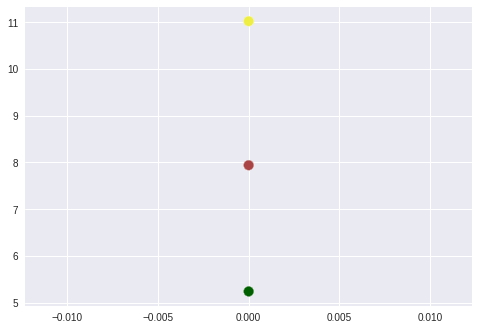

In [15]:
from matplotlib.colors import ListedColormap

# * 0 - red: many accidents
# * 1 - green: few or no accidents
# * 2 - yellow: in the middle
colors = df['group']
color_map = ListedColormap(['#AA4444', '#006000', '#EEEE44'])

latent_x = latent_representation[:, 0]
latent_y = latent_representation[:, 1]

plt.scatter(latent_x, latent_y, alpha=0.5, s=100, marker='o', edgecolors='w', cmap=color_map, c=colors)

### What a funny result: trained to (sometims almost) perfectly reproduce the groups, but not much of anything else

quite obviously we ware emphasizing the group loss way too much

## Making results more stable

* when you visualize latent spaces they should not change much when re-training or fitting additional data points
* when working with autoencoders or embeddings there are two ways to make that happen
  1. save model, do not retrain from scratch and only fit new data points with low learning rate
  1. save output from embedding and keep new latent space similar by adding to the loss function

In [0]:
# save complete model
autoencoder.save('autoencoder-v1.h5')
del autoencoder

### Option I: Saving and reloading model, retrain
* https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model

In [0]:
# later...
from tensorflow.keras.models import load_model
autoencoder = load_model('autoencoder-v1.h5')

In [0]:
main_input = autoencoder.get_layer('main_input').input
group_input = autoencoder.get_layer('group_input').input
encode = autoencoder.get_layer('encoder').output
encoder = Model(inputs=[main_input, group_input], outputs=encode)

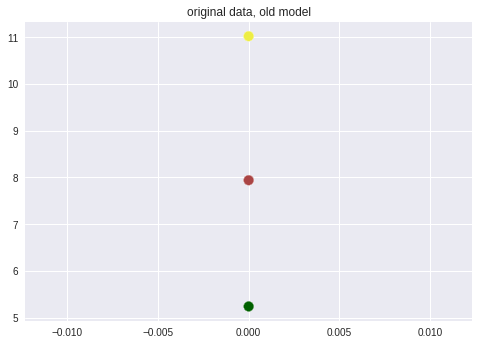

In [19]:
latent_representation = encoder.predict(x={'main_input': main, 'group_input': one_hot_groups})
colors = df['group']
color_map = ListedColormap(['#AA4444', '#006000', '#EEEE44'])

latent_x = latent_representation[:, 0]
latent_y = latent_representation[:, 1]

plt.title('original data, old model')

plt.scatter(latent_x, latent_y, alpha=0.5, s=100, marker='o', edgecolors='w', cmap=color_map, c=colors)

### Using new dataset

In [20]:
!curl -O https://raw.githubusercontent.com/DJCordhose/deep-learning-crash-course-notebooks/master/data/insurance-customers-300.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5376  100  5376    0     0  16390      0 --:--:-- --:--:-- --:--:-- 16340


In [0]:
import pandas as pd

new_df = pd.read_csv('./insurance-customers-300.csv', sep=';')
new_one_hot_groups = pd.DataFrame(to_categorical(new_df['group']), columns={'red', 'green', 'yellow'})
new_main = new_df.drop('group', axis='columns')

In [22]:
new_df.describe()

,speed,age,miles,group
count,300.000000,300.000000,300.000000,300.000000
mean,122.963333,44.000000,31.133333,1.000000
std,17.135170,16.312992,15.568885,0.817861
min,85.000000,16.000000,1.000000,0.000000
25%,109.750000,33.000000,18.000000,0.000000
50%,121.000000,42.000000,30.000000,1.000000
75%,137.000000,52.000000,43.000000,2.000000
max,161.000000,97.000000,99.000000,2.000000


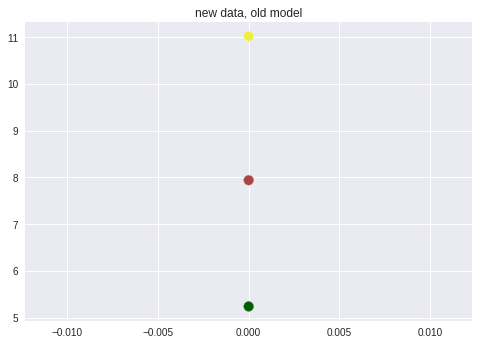

In [23]:
latent_representation = encoder.predict(x={'main_input': new_main, 'group_input': new_one_hot_groups})
colors = new_df['group']
color_map = ListedColormap(['#AA4444', '#006000', '#EEEE44'])

latent_x = latent_representation[:, 0]
latent_y = latent_representation[:, 1]

plt.title('new data, old model')

plt.scatter(latent_x, latent_y, alpha=0.5, s=100, marker='o', edgecolors='w', cmap=color_map, c=colors)

In [24]:
#default lr
# adam = keras.optimizers.Adam(lr=0.001)
# we use just half of that
adam = keras.optimizers.Adam(lr=0.0005)
# even this high learning rate can not break it (moves it quite a bit, but still same overall shape)
# adam = keras.optimizers.Adam(lr=0.1)

autoencoder.compile(optimizer=adam,
              loss={'main_output': 'mae', 'group_output': 'categorical_crossentropy'},
              loss_weights={'main_output': 1., 'group_output': 50.})

BATCH_SIZE = 1
EPOCHS=10

%time history = autoencoder.fit(\
    x={'main_input': new_main, 'group_input': new_one_hot_groups},\
    y={'main_output': new_main, 'group_output': new_one_hot_groups},\
    epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True, verbose=1)


Epoch 1/10
300/300 [==============================] - 2s 7ms/step - loss: 16.4911 - main_output_loss: 15.5391 - group_output_loss: 0.0190
Epoch 2/10
300/300 [==============================] - 2s 6ms/step - loss: 16.4797 - main_output_loss: 15.4974 - group_output_loss: 0.0196
Epoch 3/10
300/300 [==============================] - 2s 6ms/step - loss: 16.4737 - main_output_loss: 15.4851 - group_output_loss: 0.0198
Epoch 4/10
300/300 [==============================] - 2s 6ms/step - loss: 16.4681 - main_output_loss: 15.4550 - group_output_loss: 0.0203
Epoch 5/10
300/300 [==============================] - 2s 6ms/step - loss: 16.4625 - main_output_loss: 15.4595 - group_output_loss: 0.0201
Epoch 6/10
300/300 [==============================] - 2s 6ms/step - loss: 16.4572 - main_output_loss: 15.4575 - group_output_loss: 0.0200
Epoch 7/10
300/300 [==============================] - 2s 6ms/step - loss: 16.4512 - main_output_loss: 15.4483 - group_output_loss: 0.0201
Epoch 8/10
300/300 [==============

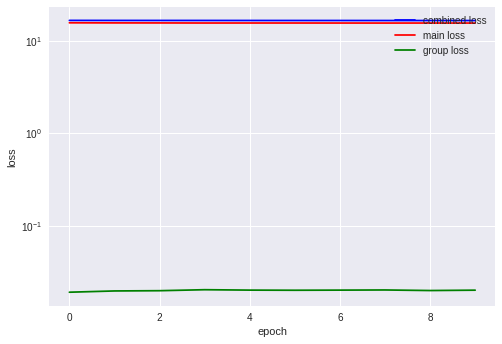

In [25]:
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')

plt.plot(history.history['loss'], 'b')
plt.plot(history.history['main_output_loss'], 'r')
plt.plot(history.history['group_output_loss'], 'g')

plt.legend(['combined loss', 'main loss', 'group loss'], loc='upper right')


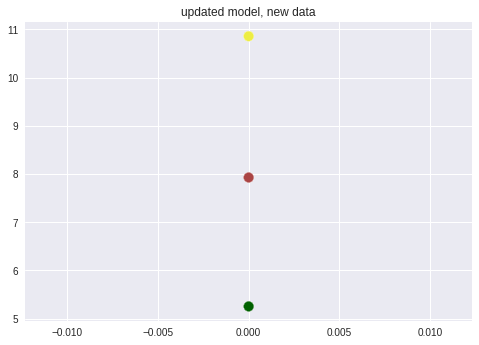

In [26]:
latent_representation = encoder.predict(x={'main_input': new_main, 'group_input': new_one_hot_groups})
colors = new_df['group']
color_map = ListedColormap(['#AA4444', '#006000', '#EEEE44'])

latent_x = latent_representation[:, 0]
latent_y = latent_representation[:, 1]

plt.title('updated model, new data')

plt.scatter(latent_x, latent_y, alpha=0.5, s=100, marker='o', edgecolors='w', cmap=color_map, c=colors)

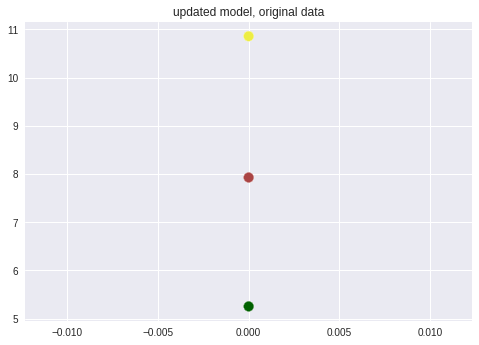

In [27]:
latent_representation = encoder.predict(x={'main_input': main, 'group_input': one_hot_groups})
colors = df['group']
color_map = ListedColormap(['#AA4444', '#006000', '#EEEE44'])

latent_x = latent_representation[:, 0]
latent_y = latent_representation[:, 1]

plt.title('updated model, original data')

plt.scatter(latent_x, latent_y, alpha=0.5, s=100, marker='o', edgecolors='w', cmap=color_map, c=colors)

### Option II: Train from scratch, but use difference to original latent representation as part of loss function


In [0]:
# start over from scratch
from tensorflow.keras.models import load_model
autoencoder = load_model('autoencoder-v1.h5')

In [0]:
main_input = autoencoder.get_layer('main_input').input
group_input = autoencoder.get_layer('group_input').input
encode = autoencoder.get_layer('encoder').output
encoder = Model(inputs=[main_input, group_input], outputs=encode)

In [0]:
new_original_latent_representation = encoder.predict(x={'main_input': new_main, 'group_input': new_one_hot_groups})
old_original_latent_representation = encoder.predict(x={'main_input': main, 'group_input': one_hot_groups})

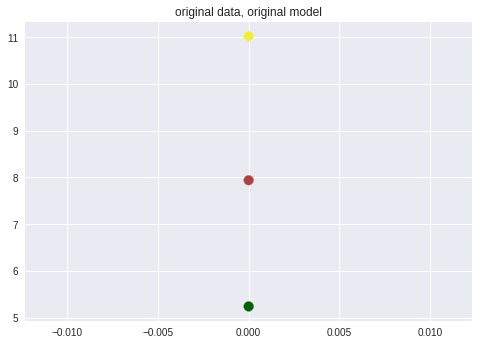

In [31]:
latent_representation = encoder.predict(x={'main_input': main, 'group_input': one_hot_groups})
colors = df['group']
color_map = ListedColormap(['#AA4444', '#006000', '#EEEE44'])

latent_x = latent_representation[:, 0]
latent_y = latent_representation[:, 1]

plt.title('original data, original model')

plt.scatter(latent_x, latent_y, alpha=0.5, s=100, marker='o', edgecolors='w', cmap=color_map, c=colors)

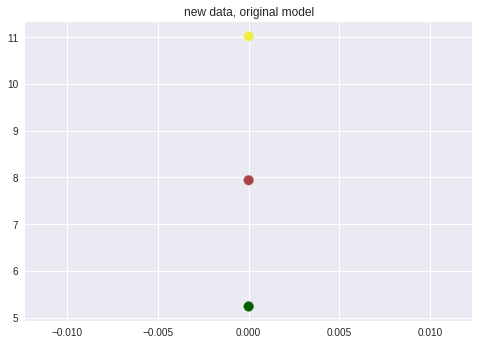

In [32]:
latent_representation = encoder.predict(x={'main_input': new_main, 'group_input': new_one_hot_groups})
colors = new_df['group']
color_map = ListedColormap(['#AA4444', '#006000', '#EEEE44'])

latent_x = latent_representation[:, 0]
latent_y = latent_representation[:, 1]

plt.title('new data, original model')

plt.scatter(latent_x, latent_y, alpha=0.5, s=100, marker='o', edgecolors='w', cmap=color_map, c=colors)

In [33]:
# often does not even train, so choose a seed known to be good
from tensorflow.keras.initializers import glorot_normal
seed= 13

# first multi in
main_input = Input(shape=(3,), name='main_input')
group_input = Input(shape=(3,), name='group_input')

# hopefully this balances out inputs to same scale
encoded_main = Dense(units=2, activation='relu', name="main_encoder", bias_initializer='zeros', kernel_initializer=glorot_normal(seed=seed))(main_input)
encoded_group = Dense(units=2, activation='relu', name="group_encoder", bias_initializer='zeros', kernel_initializer=glorot_normal(seed=seed))(group_input)

# latent representation

merged = concatenate([encoded_main, encoded_group])
# this might work as well
# merged = average([encoded_main, encoded_group])

# the effective latent encoding
encoding_dim = 2
encoded = Dense(units=encoding_dim, activation='relu', name="encoder", bias_initializer='zeros', kernel_initializer=glorot_normal(seed=seed))(merged)

# then multi out

main_output = Dense(units=3, activation='linear', name="main_output", bias_initializer='zeros', kernel_initializer=glorot_normal(seed=seed))(encoded)
group_output = Dense(units=3, activation='softmax', name="group_output", bias_initializer='zeros', kernel_initializer=glorot_normal(seed=seed))(encoded)
stability_output = encoded # just the latent space as output

# autoencoder = Model(inputs=[main_input, group_input], outputs=[main_output, group_output, stability_output])
autoencoder = Model(inputs=[main_input, group_input], outputs=[main_output, group_output])

# adam = keras.optimizers.Adam(lr=0.001)
adam = keras.optimizers.Adam(lr=0.01)

# autoencoder.compile(optimizer=adam,
#               loss={'main_output': 'mae', 'group_output': 'categorical_crossentropy', 'encoder': 'mae' },
#               loss_weights={'main_output': 1., 'group_output': 50., 'encoder': 10.})

autoencoder.compile(optimizer=adam,
              loss={'main_output': 'mae', 'group_output': 'categorical_crossentropy'},
              loss_weights={'main_output': 1., 'group_output': 1000.})

BATCH_SIZE = 1
EPOCHS=20

# %time history = autoencoder.fit(\
#     x={'main_input': new_main, 'group_input': new_one_hot_groups},\
#     y={'main_output': new_main, 'group_output': new_one_hot_groups, 'encoder': new_original_latent_representation},\
#     epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True, verbose=1)

%time history = autoencoder.fit(\
    x={'main_input': new_main, 'group_input': new_one_hot_groups},\
    y={'main_output': new_main, 'group_output': new_one_hot_groups},\
    epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

Epoch 1/20
300/300 [==============================] - 2s 8ms/step - loss: 1075.0396 - main_output_loss: 62.5825 - group_output_loss: 1.0125
Epoch 2/20
300/300 [==============================] - 2s 7ms/step - loss: 710.2245 - main_output_loss: 51.3525 - group_output_loss: 0.6589
Epoch 3/20
300/300 [==============================] - 2s 6ms/step - loss: 554.2364 - main_output_loss: 43.3977 - group_output_loss: 0.5108
Epoch 4/20
300/300 [==============================] - 2s 6ms/step - loss: 400.3064 - main_output_loss: 37.1499 - group_output_loss: 0.3632
Epoch 5/20
300/300 [==============================] - 2s 6ms/step - loss: 367.2637 - main_output_loss: 35.1426 - group_output_loss: 0.3321
Epoch 6/20
300/300 [==============================] - 2s 6ms/step - loss: 283.9395 - main_output_loss: 34.4017 - group_output_loss: 0.2495
Epoch 7/20
300/300 [==============================] - 2s 6ms/step - loss: 216.9488 - main_output_loss: 33.4983 - group_output_loss: 0.1835
Epoch 8/20
300/300 [======

In [0]:
main_input = autoencoder.get_layer('main_input').input
group_input = autoencoder.get_layer('group_input').input
encode = autoencoder.get_layer('encoder').output
encoder = Model(inputs=[main_input, group_input], outputs=encode)

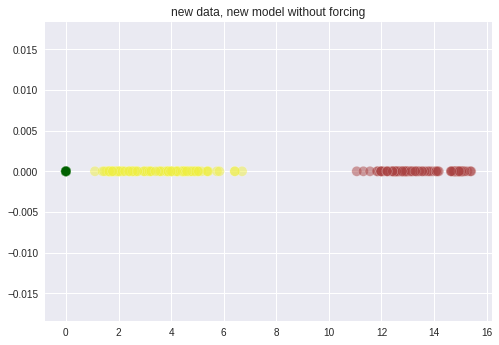

In [35]:
latent_representation = encoder.predict(x={'main_input': new_main, 'group_input': new_one_hot_groups})
colors = new_df['group']
color_map = ListedColormap(['#AA4444', '#006000', '#EEEE44'])

latent_x = latent_representation[:, 0]
latent_y = latent_representation[:, 1]

plt.title('new data, new model without forcing')

plt.scatter(latent_x, latent_y, alpha=0.5, s=100, marker='o', edgecolors='w', cmap=color_map, c=colors)

In [36]:
# often does not even train, so choose a seed known to be good
from tensorflow.keras.initializers import glorot_normal
seed= 13

# first multi in
main_input = Input(shape=(3,), name='main_input')
group_input = Input(shape=(3,), name='group_input')

# hopefully this balances out inputs to same scale
encoded_main = Dense(units=2, activation='relu', name="main_encoder", bias_initializer='zeros', kernel_initializer=glorot_normal(seed=seed))(main_input)
encoded_group = Dense(units=2, activation='relu', name="group_encoder", bias_initializer='zeros', kernel_initializer=glorot_normal(seed=seed))(group_input)

# latent representation

merged = concatenate([encoded_main, encoded_group])
# this might work as well
# merged = average([encoded_main, encoded_group])

# the effective latent encoding
encoding_dim = 2
encoded = Dense(units=encoding_dim, activation='relu', name="encoder", bias_initializer='zeros', kernel_initializer=glorot_normal(seed=seed))(merged)

# then multi out

main_output = Dense(units=3, activation='linear', name="main_output", bias_initializer='zeros', kernel_initializer=glorot_normal(seed=seed))(encoded)
group_output = Dense(units=3, activation='softmax', name="group_output", bias_initializer='zeros', kernel_initializer=glorot_normal(seed=seed))(encoded)
stability_output = encoded # just the latent space as output

autoencoder = Model(inputs=[main_input, group_input], outputs=[main_output, group_output, stability_output])

# adam = keras.optimizers.Adam(lr=0.001)
adam = keras.optimizers.Adam(lr=0.01)

autoencoder.compile(optimizer=adam,
              loss={'main_output': 'mae', 'group_output': 'categorical_crossentropy', 'encoder': 'mae' },
              loss_weights={'main_output': 1., 'group_output': 100., 'encoder': 100.})


BATCH_SIZE = 1
EPOCHS=20

%time history = autoencoder.fit(\
    x={'main_input': new_main, 'group_input': new_one_hot_groups},\
    y={'main_output': new_main, 'group_output': new_one_hot_groups, 'encoder': new_original_latent_representation},\
    epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

Epoch 1/20
300/300 [==============================] - 3s 9ms/step - loss: 305.4781 - main_output_loss: 51.8509 - group_output_loss: 1.1185 - encoder_loss: 1.4178
Epoch 2/20
300/300 [==============================] - 2s 7ms/step - loss: 135.6641 - main_output_loss: 33.4648 - group_output_loss: 0.9922 - encoder_loss: 0.0298
Epoch 3/20
300/300 [==============================] - 2s 7ms/step - loss: 116.8377 - main_output_loss: 25.4114 - group_output_loss: 0.8898 - encoder_loss: 0.0245
Epoch 4/20
300/300 [==============================] - 2s 7ms/step - loss: 103.9711 - main_output_loss: 22.4340 - group_output_loss: 0.7896 - encoder_loss: 0.0257
Epoch 5/20
300/300 [==============================] - 2s 7ms/step - loss: 96.7130 - main_output_loss: 21.4369 - group_output_loss: 0.7303 - encoder_loss: 0.0225
Epoch 6/20
300/300 [==============================] - 2s 7ms/step - loss: 90.2812 - main_output_loss: 21.1249 - group_output_loss: 0.6676 - encoder_loss: 0.0240
Epoch 7/20
300/300 [==========

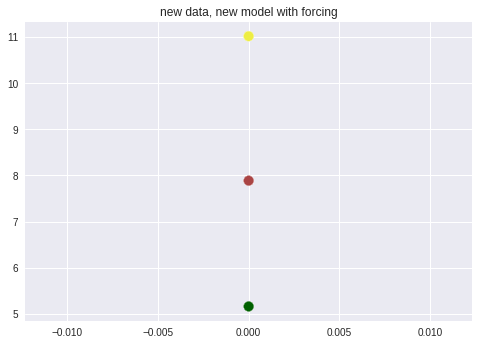

In [37]:
main_input = autoencoder.get_layer('main_input').input
group_input = autoencoder.get_layer('group_input').input
encode = autoencoder.get_layer('encoder').output
encoder = Model(inputs=[main_input, group_input], outputs=encode)

latent_representation = encoder.predict(x={'main_input': new_main, 'group_input': new_one_hot_groups})
colors = new_df['group']
color_map = ListedColormap(['#AA4444', '#006000', '#EEEE44'])

latent_x = latent_representation[:, 0]
latent_y = latent_representation[:, 1]

plt.title('new data, new model with forcing')

plt.scatter(latent_x, latent_y, alpha=0.5, s=100, marker='o', edgecolors='w', cmap=color_map, c=colors)